# Vera Data Engineer Programming Exercise

In the code below, I walk through the following steps:
1. Identify websites where county-level incarceration data is stored
2. Scrape those websites systematically to obtain the website's HTML
3. Parse the HTML and pull out components of the data tables
4. Append data from the tables to a dataframe containing data from all years
5. Merge county FIPS code onto prison population dataframe
6. Export dataframe to CSV

Data should cover years FY1995-1996, FY2005-2006, and FY2014-2015

In [17]:
# Import packages
import pandas as pd
import requests
import bs4
import os
import numpy as np
import matplotlib.pyplot as plt

## Step 1: Define functions

I chose to use functions because we might want to apply the same code over multiple different websites. Scrapy is another good alternative for pulling data from multiple web pages, but because this exercise is small in scope, I decided to rely on requests and beautiful soup instead.

In [18]:
def web_scraper(url, yr):
    """
    This function searches the WayBack Archive for the county of commitment tables
    for each year, scrapes the corresponding web pages, and returns the website's HTML content.
    :param url: url prefix 
    :param yr: report year, formatted as 'y1y2'
    :return res: response object containing HTML of the webpage
    """
    
    # The name of the county-level population table changes over the years.
        # I add the correct url stem based on the year.
    if yr != "9596":
        suffix = "/ip_county_commitment.html"
    else:
        suffix = "/ipt2.html"
    
    # Format URL
    urlFormatted = (url + suffix).format(yr)
    
    # Pass a GET request to the website and pull the archived URL from
        # the resultant JSON object.            
    r = requests.get('http://archive.org/wayback/available?url={}'.format(urlFormatted))
    archived_link = r.json()['archived_snapshots']['closest']['url']
    
    # Pass a GET request to the archived link    
    res = requests.get(archived_link)
    
    return res

In [19]:
def parse_html(res):
    """
    This function takes in a response object, scrapes its HTML content for tables, 
    and pulls out every row in the table.
    :param res: response object containing HTML of the webpage
    :return rows: the rows of the population count table from the webpage
    """
    
    rows = []
    
    # Use Beautiful Soup to parse the HTML and find all items tagged as a table
    soupText = bs4.BeautifulSoup(res.text, "html.parser")
    table = soupText.findAll("table")
        
    # Pull out all the rows in the table
    for item in table:
        for i in item.findAll("tr"):
            rows.append(i.text)

    return rows

In [20]:
def create_master_df(rows, yr, df):
    """
    This function concatenates rows from the data tables into one large data frame. 
    It searches through the rows differently for different years because the 
    reported fields in the table change from year to year.
    :param rows: rows from the population table
    :param yr: report year, formatted as 'y1y2'
    :param df: an empty data frame to which we append the data
    :return df: a data frame filled with the webpage's data
    """
    
    for row in rows:
        if yr != "9596":
            if "%" in row:
                temp = row.split("\n")
                df = df.append({"county": temp[1].strip() + " County", "state": "FL", "year": yr, "prisontotal": int(temp[2].strip().replace(",", ""))}, ignore_index = True)
        else:
            if "next" not in row and "Percent" not in row: # Remove rows that do not contain data
                temp = row.split("\n")
                df = df.append({"county": temp[1].strip() + " County", "state": "FL", "year": yr, "prisontotal": int(temp[-3].strip().replace(",", ""))}, ignore_index = True)

    return df

In [21]:
def merge_countyfips(df):
    """
    This function merges county FIPS codes to county names and exports the merged
    data frame to a CSV.
    :param df: county-level inmate populations
    :return dfNew: a modified dataframe that includes county FIPS codes
    """
    
    # Read in Census FIPS code text file
    counties = pd.read_csv("https://www2.census.gov/geo/docs/reference/codes/files/st12_fl_cou.txt", sep = ",", names = ["state", "statecode", "countycode", "county", "header"])

    # Create a column with countyfips
    counties ['countyfips'] = counties.statecode.astype(str) + counties.countycode.astype(str).apply(lambda x:  "0"* (3 - len(x)) + x)
    
    # Change "Dade County" to "Miami-Dade County"
    df.loc[df.county == "Dade County", "county"] = "Miami-Dade County"
    
    # Create a proper year pair
    df["yr"] = df.year.apply(year_formatter)
    
    # Merge Florida county data with prison population data
    dfNew = pd.merge(df, counties [["county", "countyfips"]], on = "county", how = "left")
    
    # Check merge
    print(dfNew.head())

    # Export to CSV
    dfNew.to_csv("florida_prison_populations.csv", index = False) 
    
    return dfNew

In [22]:
def year_formatter(y1y2):
    """
    This function formats a time period in "y1y2" format to "Year 1 - Year 2" format. 
    For example, "9596" will become "1995-1996".
    :param y1y2: two years displayed in short format
    :return: a longer string displaying the time period under consideration
    """
    return str(1900 + int(y1y2[0:2])) +"-" + str(1900 + int(y1y2[2:4])) if int(y1y2[0:2]) > 50 else str(2000 + int(y1y2[0:2])) +"-" + str(2000 + int(y1y2[2:4])) 
    

## Step 2: Run functions 

First, define the variables passed as arguments to the functions.

In [23]:
# Subset of years required for the exercise
yrs = ["9596","0506","1415"]

# Define the empty dataframe
countyPrisonPop = pd.DataFrame(columns = ["county", "state", "year", "prisontotal"])

# Define the main URL
url = "http://www.dc.state.fl.us/pub/annual/{}/stats"

Loop over each year to create the population data frame.

In [24]:
for yr in yrs:    
    res = web_scraper(url, yr)
    rows = parse_html(res)
    
    countyPrisonPop = create_master_df(rows, yr, countyPrisonPop)   

In [25]:
# Look at the new data frame
countyPrisonPop.head()

,county,state,year,prisontotal
0,Alachua County,FL,9596,819
1,Baker County,FL,9596,123
2,Bay County,FL,9596,1122
3,Bradford County,FL,9596,262
4,Brevard County,FL,9596,1583


In [26]:
# Merge in county FIPS codes
countyFIPS_pop = merge_countyfips(countyPrisonPop)

            county state  year prisontotal         yr countyfips
0   Alachua County    FL  9596         819  1995-1996      12001
1     Baker County    FL  9596         123  1995-1996      12003
2       Bay County    FL  9596        1122  1995-1996      12005
3  Bradford County    FL  9596         262  1995-1996      12007
4   Brevard County    FL  9596        1583  1995-1996      12009


## Step 3: Check data quality

In [27]:
# How many rows do we have?
countyFIPS_pop.shape

(208, 6)

In [28]:
# What are the data types?
countyFIPS_pop.dtypes
countyFIPS_pop["prisontotal"] = countyFIPS_pop["prisontotal"].astype(int)
countyFIPS_pop.dtypes

county         object
state          object
year           object
prisontotal     int64
yr             object
countyfips     object
dtype: object

The *prisontotal* variable should be a numeric data type, so I coerce it to integer type above.

In [29]:
# How many observations are missing?
countyFIPS_pop.isnull().values.sum()

7

In [30]:
# Which rows have missing observations?
countyFIPS_pop[countyFIPS_pop.isnull().T.any().T]

,county,state,year,prisontotal,yr,countyfips
67,Interstate County,FL,9596,133,1995-1996,NaN
68,Data Unavailable County,FL,9596,67,1995-1996,NaN
69,TOTAL County,FL,9596,64333,1995-1996,NaN
137,Other States County,FL,0506,154,2005-2006,NaN
138,Total County,FL,0506,88576,2005-2006,NaN
206,Other States County,FL,1415,137,2014-2015,NaN
207,Total County,FL,1415,100050,2014-2015,NaN


All the missing observations occurred in the last data frame merge. It makes sense that the counties above do not have corresponding Florida county FIPs codes, because they represent aggregate or masked data.

In [31]:
# How does prison population vary within a county over all years?
countyFIPS_pop[["county", "prisontotal"]].groupby("county").aggregate(np.var)

,prisontotal
county,
Alachua County,2.275503e+05
Baker County,1.340333e+03
Bay County,1.884363e+05
Bradford County,1.836333e+03
Brevard County,5.191043e+05
Broward County,4.381210e+05
Calhoun County,1.036000e+03
Charlotte County,5.139700e+04
Citrus County,1.776643e+05


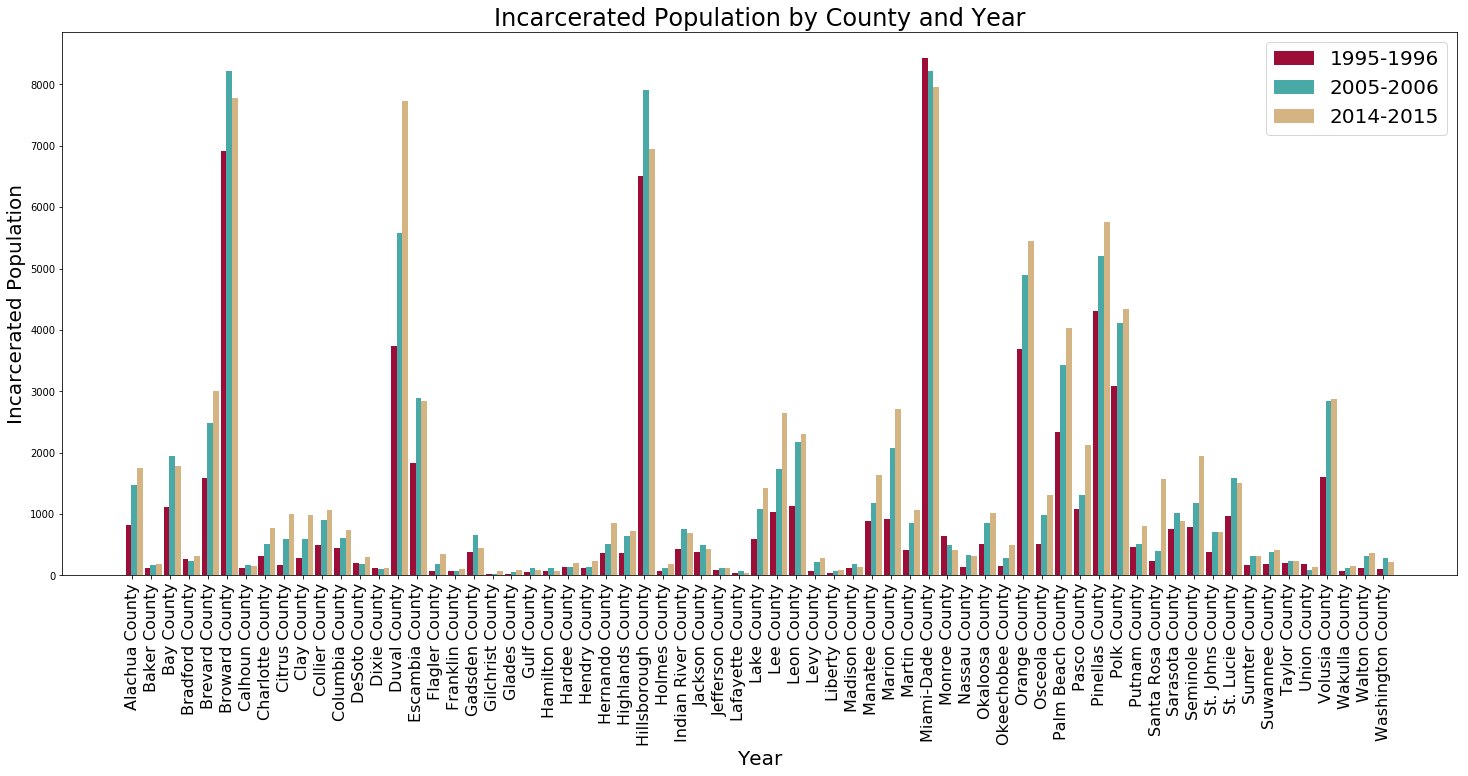

In [32]:
# What are the counties with the highest incarcerated populations?

    # Reshape data
plot_dat = countyFIPS_pop.loc[countyFIPS_pop["countyfips"].isnull() == False]
plot_dat = plot_dat[["county","yr","prisontotal"]].pivot(index = "county", 
           columns = "yr", values = "prisontotal")
plot_dat = plot_dat.reset_index()

    # Set plot parameters
fig, ax = plt.subplots(figsize=(25,10))
pos = np.arange(len(plot_dat["1995-1996"])) * 2

    # Add bars for each year
plt.bar(pos + 0.6, plot_dat["1995-1996"], width = 0.6, color = "#9C0D38", label = "1995-1996")
plt.bar(pos + 0.6*2, plot_dat["2005-2006"], width = 0.6, color = "#48A9A6", label = "2005-2006")
plt.bar(pos + 0.6*3, plot_dat["2014-2015"], width = 0.6, color = "#D4B483",label = "2014-2015")

    # Format axes
ax.set_xlabel("Year", fontsize = 20)
ax.set_ylabel("Incarcerated Population", fontsize = 20)
ax.set_title("Incarcerated Population by County and Year", fontsize = 24)
ax.set_xticks(pos + 1 )
ax.set_xticklabels(plot_dat['county'], rotation='vertical', fontsize = 16)

    # Show plot
plt.legend(["1995-1996", "2005-2006", "2014-2015"], loc = "upper right", fontsize = 20)
plt.show()
